In [1]:
import os
import os.path
import cv2
import glob
import imutils
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
#from helpers import resize_to_fit
#from pilkit.processors import ResizeToFit
from keras.models import load_model

In [2]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

In [4]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
captcha = "/content/drive/MyDrive/AML_Proj/generated_captcha_images.zip"
  
# opening the zip file in READ mode 
with ZipFile(captcha, 'r') as zip:  
    # extracting all the files 
    zip.extractall()

In [5]:
CAPTCHA_IMAGE_FOLDER = "/content/generated_captcha_images"
OUTPUT_FOLDER = "extracted_letter_images"


# Get a list of all the captcha images we need to process
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
counts = {}

In [6]:
captcha_image_files

['/content/generated_captcha_images/DVZ6.png',
 '/content/generated_captcha_images/ZP64.png',
 '/content/generated_captcha_images/35J4.png',
 '/content/generated_captcha_images/PPEA.png',
 '/content/generated_captcha_images/LBEG.png',
 '/content/generated_captcha_images/AVAD.png',
 '/content/generated_captcha_images/77P7.png',
 '/content/generated_captcha_images/4K2F.png',
 '/content/generated_captcha_images/CCES.png',
 '/content/generated_captcha_images/DDCL.png',
 '/content/generated_captcha_images/NHH8.png',
 '/content/generated_captcha_images/NYR7.png',
 '/content/generated_captcha_images/P8ZR.png',
 '/content/generated_captcha_images/TV5L.png',
 '/content/generated_captcha_images/Z852.png',
 '/content/generated_captcha_images/3LL6.png',
 '/content/generated_captcha_images/DTVE.png',
 '/content/generated_captcha_images/2PEM.png',
 '/content/generated_captcha_images/5TKW.png',
 '/content/generated_captcha_images/JREP.png',
 '/content/generated_captcha_images/2UQ2.png',
 '/content/ge

In [7]:
__builtins__.zip(letter_image_regions, captcha_correct_text)

NameError: ignored

In [8]:
# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    #contours = contours[0] if imutils.is_cv2() else contours[1]
    contours = contours[0]
    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    # Save out each letter as a single image
    for letter_bounding_box, letter_text in __builtins__.zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1


Streaming output truncated to the last 5000 lines.
[INFO] processing image 4956/9955
[INFO] processing image 4957/9955
[INFO] processing image 4958/9955
[INFO] processing image 4959/9955
[INFO] processing image 4960/9955
[INFO] processing image 4961/9955
[INFO] processing image 4962/9955
[INFO] processing image 4963/9955
[INFO] processing image 4964/9955
[INFO] processing image 4965/9955
[INFO] processing image 4966/9955
[INFO] processing image 4967/9955
[INFO] processing image 4968/9955
[INFO] processing image 4969/9955
[INFO] processing image 4970/9955
[INFO] processing image 4971/9955
[INFO] processing image 4972/9955
[INFO] processing image 4973/9955
[INFO] processing image 4974/9955
[INFO] processing image 4975/9955
[INFO] processing image 4976/9955
[INFO] processing image 4977/9955
[INFO] processing image 4978/9955
[INFO] processing image 4979/9955
[INFO] processing image 4980/9955
[INFO] processing image 4981/9955
[INFO] processing image 4982/9955
[INFO] processing image 4983/99

In [9]:
LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
                          pickle.dump(lb, f)




In [10]:
# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)

# Save the trained model to disk
model.save("/content/drive/MyDrive/AML_Proj/captcha_model.hdf5")


Epoch 1/10
909/909 [==============================] - 3s 4ms/step - loss: 0.2269 - accuracy: 0.9442 - val_loss: 0.0245 - val_accuracy: 0.9947
Epoch 2/10
909/909 [==============================] - 3s 3ms/step - loss: 0.0111 - accuracy: 0.9972 - val_loss: 0.0203 - val_accuracy: 0.9960
Epoch 3/10
909/909 [==============================] - 3s 3ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0194 - val_accuracy: 0.9961
Epoch 4/10
909/909 [==============================] - 3s 3ms/step - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.0194 - val_accuracy: 0.9958
Epoch 5/10
909/909 [==============================] - 3s 3ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0246 - val_accuracy: 0.9947
Epoch 6/10
909/909 [==============================] - 3s 3ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0184 - val_accuracy: 0.9964
Epoch 7/10
909/909 [==============================] - 3s 3ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0165 - val_accuracy: 0.9970
Epoch 

In [14]:
model.save('/content/drive/MyDrive/AML_Proj/captcha.h5')

CAPTCHA text is: C4F7


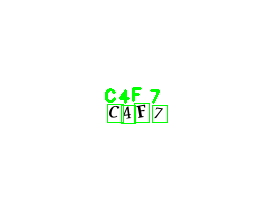

In [12]:
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"


# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model("/content/drive/MyDrive/AML_Proj/captcha_model.hdf5")

# Grab some random CAPTCHA images to test against.
# In the real world, you'd replace this section with code to grab a real
# CAPTCHA image from a live website.
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(1,), replace=False)

# loop over the image paths
for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 100, 100, 100, 100, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    #contours = contours[0] if imutils.is_cv2() else contours[1]
    contours = contours[0]
    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the lektters
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)
    
    
    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

    from google.colab.patches import cv2_imshow
    # Show the annotated image
    cv2_imshow(output)
    cv2.waitKey()
    

In [17]:
import tensorflow
tensorflow.__version__

'2.3.0'